In [ ]:
# 1. 데이터셋 준비

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# 데이터셋 로드
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

# 클래스 정보 확인
class_names = metadata.features['label'].names
print(f"클래스 종류: {class_names} (총 {len(class_names)}개)")


클래스 종류: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'] (총 5개)


In [ ]:
# 2. 데이터 전처리 파이프라인

In [2]:
# 이미지 표준화 (224x224 크기 조정)
IMG_SIZE = 224
BATCH_SIZE = 32

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# 데이터 증강 레이어
augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1)
])

# 데이터 파이프라인 구성
train_batches = raw_train.map(format_image).cache().shuffle(1000)
train_batches = train_batches.map(lambda x,y: (augmentation_layers(x), y))
train_batches = train_batches.batch(BATCH_SIZE).prefetch(1)

val_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = raw_test.map(format_image).batch(BATCH_SIZE).prefetch(1)


In [ ]:
# 3. 전이 학습 모델 설계 (MobileNetV2 기반)

In [3]:
# 기본 모델 구성
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # 기본 모델 가중치 고정

# 분류 헤드 추가
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# 4. 모델 학습 및 성능 평가

In [4]:
# 학습 실행 (10 에포크)
history = model.fit(
    train_batches,
    validation_data=val_batches,
    epochs=10
)

# 성능 평가
test_loss, test_acc = model.evaluate(test_batches)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")


Epoch 1/10
92/92 [==============================] - 38s 334ms/step - loss: 1.2273 - accuracy: 0.5109 - val_loss: 0.7810 - val_accuracy: 0.7384
Epoch 2/10
92/92 [==============================] - 28s 304ms/step - loss: 0.7263 - accuracy: 0.7347 - val_loss: 0.5711 - val_accuracy: 0.8093
Epoch 3/10
92/92 [==============================] - 28s 305ms/step - loss: 0.5782 - accuracy: 0.7813 - val_loss: 0.4885 - val_accuracy: 0.8420
Epoch 4/10
92/92 [==============================] - 28s 305ms/step - loss: 0.5154 - accuracy: 0.8151 - val_loss: 0.4568 - val_accuracy: 0.8420
Epoch 5/10
92/92 [==============================] - 28s 304ms/step - loss: 0.4702 - accuracy: 0.8355 - val_loss: 0.4267 - val_accuracy: 0.8474
Epoch 6/10
92/92 [==============================] - 28s 304ms/step - loss: 0.4428 - accuracy: 0.8365 - val_loss: 0.4148 - val_accuracy: 0.8583
Epoch 7/10
92/92 [==============================] - 28s 305ms/step - loss: 0.4167 - accuracy: 0.8481 - val_loss: 0.4058 - val_accuracy: 0.8665

In [ ]:
# 성능 시각화

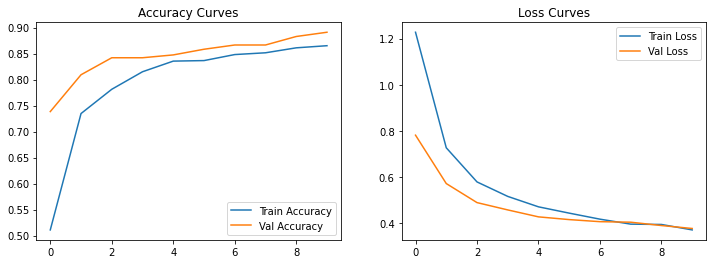

In [5]:
# 정확도/손실 곡선
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()
